código que simula un fluido continuo utilizando el método de Lattice Boltzmann (LBM).El código simulará el flujo de un fluido en una cavidad cuadrada con una pared superior móvil (problema de la cavidad).

El método de Lattice Boltzmann (LBM) con un modelo D2Q9 es una técnica de simulación de fluidos que opera a nivel mesoscópico, entre las escalas macroscópica y microscópica. Para el modelo D2Q9 en dos dimensiones con 9 velocidades discretas:

1. Discretización del espacio y velocidades:
   - El espacio se divide en una malla cuadrada uniforme.
   - Cada nodo tiene 9 velocidades discretas (e_i), incluyendo una velocidad nula:
     e_0 = (0,0)
     e_1-4 = (±1,0), (0,±1)
     e_5-8 = (±1,±1)

2. Función de distribución:
   - Se define una función de distribución f_i(x,t) para cada velocidad discreta en cada nodo.

3. Evolución temporal:
   La ecuación de evolución del LBM es:
   f_i(x + e_i*dt, t + dt) = f_i(x,t) - (1/τ) * (f_i(x,t) - f_i^eq(x,t))
   Donde:
   - τ es el tiempo de relajación
   - f_i^eq es la función de distribución de equilibrio

4. Función de equilibrio:
   f_i^eq = w_i * ρ * [1 + 3(e_i · u) + 9/2(e_i · u)^2 - 3/2(u · u)]
   Donde:
   - w_i son los pesos: w_0 = 4/9, w_1-4 = 1/9, w_5-8 = 1/36
   - ρ es la densidad del fluido
   - u es la velocidad macroscópica

5. Cálculo de cantidades macroscópicas:
   - Densidad: ρ = Σ f_i
   - Velocidad: u = (1/ρ) * Σ (e_i * f_i)

6. Condiciones de frontera:
   Se aplican condiciones específicas en los bordes del dominio, como rebote en las paredes o velocidad prescrita.

7. Pasos de simulación:
   a) Streaming: las distribuciones se propagan a nodos vecinos.
   b) Colisión: se aplica el operador de colisión (término de relajación).
   c) Cálculo de cantidades macroscópicas.
   d) Aplicación de condiciones de frontera.

Este modelo D2Q9 es capaz de simular flujos incompresibles en régimen laminar y es particularmente eficiente para implementaciones paralelas debido a la naturaleza local de sus operaciones.

ValueError: could not broadcast input array from shape (3,200) into shape (200,)

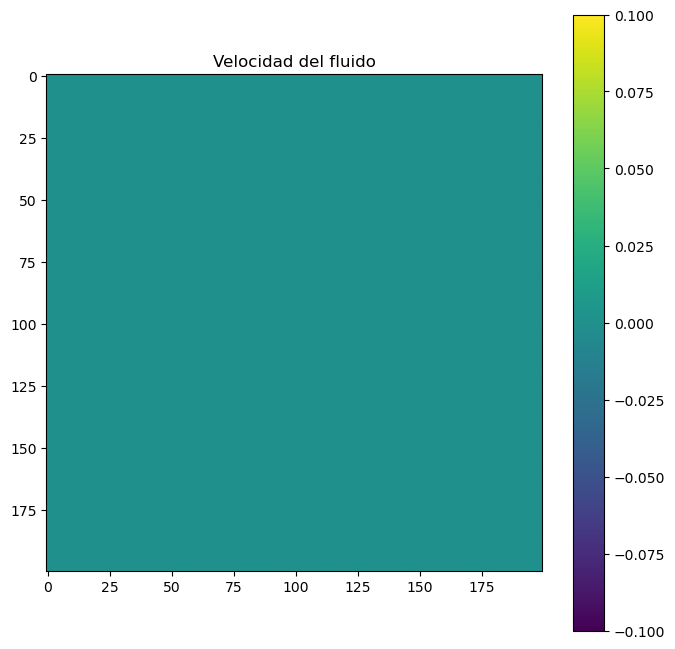

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parámetros de la simulación
Nx, Ny = 200, 200  # Tamaño del dominio
tau = 0.8  # Tiempo de relajación
Nt = 1000  # Número de pasos de tiempo

# Velocidades del modelo D2Q9
c = np.array([(x, y) for x in [0, -1, 1] for y in [0, -1, 1]])
weights = np.array([4/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9])

# Inicialización
f = np.ones((Ny, Nx, 9)) + 0.01 * np.random.randn(Ny, Nx, 9)
f[:, :, 3] = 2.2

# Función para calcular las cantidades macroscópicas
def macroscopic(f):
    rho = np.sum(f, axis=2)
    u = np.zeros((Ny, Nx, 2))
    for i in range(9):
        u[:, :, 0] += c[i, 0] * f[:, :, i]
        u[:, :, 1] += c[i, 1] * f[:, :, i]
    u /= rho[:, :, np.newaxis]
    return rho, u

# Función de equilibrio
def equilibrium(rho, u):
    cu = 3 * np.einsum('ij,kij->kij', c, u)
    usq = 3/2 * np.sum(u**2, axis=2)
    feq = np.zeros((Ny, Nx, 9))
    for i in range(9):
        feq[:, :, i] = rho * weights[i] * (1 + cu[:, :, i] + 0.5 * cu[:, :, i]**2 - usq)
    return feq

# Configuración de la visualización
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(np.zeros((Ny, Nx)), cmap='viridis', animated=True)
ax.set_title('Velocidad del fluido')
plt.colorbar(im)

# Función de actualización para la animación
def update(frame):
    global f
    
    # Streaming
    for i in range(9):
        f[:, :, i] = np.roll(np.roll(f[:, :, i], c[i, 0], axis=1), c[i, 1], axis=0)
    
    # Condiciones de frontera - paredes
    f[0, :, [2, 5, 6]] = f[0, :, [4, 7, 8]]  # Pared inferior
    f[-1, :, [4, 7, 8]] = f[-1, :, [2, 5, 6]]  # Pared superior
    f[:, 0, [1, 5, 8]] = f[:, 0, [3, 7, 6]]  # Pared izquierda
    f[:, -1, [3, 7, 6]] = f[:, -1, [1, 5, 8]]  # Pared derecha
    
    # Pared superior móvil
    u_wall = np.array([0.1, 0])
    rho_wall = f[-1, :, [0, 1, 3]].sum(axis=1) + 2 * f[-1, :, [2, 5, 6]].sum(axis=1)
    f[-1, :, 4] = f[-1, :, 2] - 2/3 * rho_wall[:, np.newaxis] * u_wall[0]
    f[-1, :, 7] = f[-1, :, 5] + 0.5 * (f[-1, :, 1] - f[-1, :, 3]) - 1/6 * rho_wall[:, np.newaxis] * u_wall[0]
    f[-1, :, 8] = f[-1, :, 6] - 0.5 * (f[-1, :, 1] - f[-1, :, 3]) - 1/6 * rho_wall[:, np.newaxis] * u_wall[0]
    
    # Colisión
    rho, u = macroscopic(f)
    feq = equilibrium(rho, u)
    f += -(1/tau) * (f - feq)
    
    # Actualizar la visualización
    im.set_array(np.sqrt(u[:, :, 0]**2 + u[:, :, 1]**2))
    return [im]

# Crear la animación
anim = FuncAnimation(fig, update, frames=Nt, interval=50, blit=True)
plt.close(fig)  # Evita mostrar la figura dos veces en notebooks

# Para mostrar en un notebook de Jupyter:
HTML(anim.to_jshtml())

